In [1]:
# !pip install SimPEG
# !pip install empymod

# Marine CSEM apps

This notebook is designed to understand fundamentals of marine controlled-source electromagnetics (CSEM). 
Backend engine is built upon https://github.com/prisae/empymod, and corresponding article can be found in 
the leading edge: 

Werthmüller, D., 2017, Getting started with controlled-source electromagnetic 1D modeling: The Leading Edge, 36, 352-355; doi: 10.1190/tle36040352.1.

In [2]:
import numpy as np                      # NumPy
import matplotlib.pyplot as plt         # Matplotlib
from matplotlib import rcParams         # To adjust some plot settings
from empymod import bipole, utils       # Load required empymod functions
# Plot-style adjustments
%pylab inline
rcParams['font.size'] = 14# Set a nice colormap!
plt.set_cmap(plt.get_cmap('viridis'))

Populating the interactive namespace from numpy and matplotlib


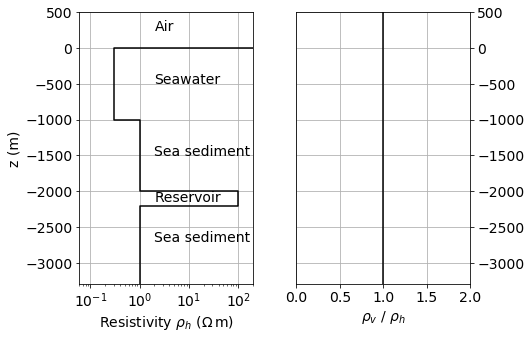

In [3]:
d1, d2, d3, d4 = 0., 1000., 2000., 2200.
rho0, rho1, rho2, rho3, rho4 = 1e8, 0.3, 1., 100., 1.
lamda0, lamda1, lamda2, lamda3, lamda4 = 1., 1., 1., 1., 1.

depth = [d1, d2, d3, d4]       # Layer boundaries
res =   [rho0,  rho1,  rho2,  rho3, rho4]  # Anomaly resistivities
aniso = [lamda0, lamda1, lamda2, lamda3, lamda4]  # Layer anisotropies (same for anomaly and background)

# Modelling parameters
verb = 1

# Spatial parameters
zsrc = 999.               # Src-depth
dx = 500.
dy = 500.
x = np.r_[-100., np.arange(10)*dx + dx]   # Offsets
y = np.r_[-100., np.arange(10)*dy + dy]   # Offsets

mid_d = (np.array(depth)[:-1] + np.array(depth)[1:]) *  0.5
z = np.r_[-500, depth[0], mid_d[0], depth[1], mid_d[1], mid_d[2], depth[2] + 500., depth[2]+1000.]
nlayers = 5
srcloc = np.r_[0., 0., zsrc]

pdepth = np.repeat(np.r_[-500, depth], 2)
pdepth[:-1] = pdepth[1:]
pdepth[-1] = 2*depth[-1]
pres = np.repeat(res, 2)
pani = np.repeat(aniso, 2)

# Create figure
fig = plt.figure(figsize=(7,5), facecolor='w')
fig.subplots_adjust(wspace=.25, hspace=.4)
# plt.suptitle(name, fontsize=20)

# Plot Resistivities
ax1 = plt.subplot(1, 2, 1)
plt.plot(pres, -pdepth, 'k')
plt.xscale('log')
plt.xlim([.2*np.array(res).min(), 2*np.array(res)[1:].max()])
plt.ylim([-1.5*depth[-1], 500])
plt.ylabel('z (m)')
plt.xlabel(r'Resistivity $\rho_h\ (\Omega\,\rm{m})$')

# Plot anisotropies
ax2 = plt.subplot(1, 2, 2)
plt.plot(pani, -pdepth, 'k')
plt.xlim([0, 2])
plt.ylim([-1.5*depth[-1], 500])
plt.xlabel(r'$\rho_v$ / $\rho_h$')
ax2.yaxis.tick_right()
ax1.grid(True)
ax2.grid(True)
ax1.text(2, -0.5*(-500 + d1), "Air")
ax1.text(2, -0.5*(d1 + d2), "Seawater")
ax1.text(2, -0.5*(d2 + d3), "Sea sediment")
ax1.text(2, -0.5*(d3 + d4) - 50., "Reservoir")
ax1.text(2, -0.5*(d4 + d4+1000.), "Sea sediment")

plt.show()

In [4]:
# Load required empymod functions
from empymod import bipole, utils       
def csem_layered_earth(
    srcloc, rxlocs, depth, res, aniso, frequency,
    nlayers=5, src_type = "electric", rx_type = "electric",
    src_direction="x", rx_direction="x", verb=0
):   
    """
    Simulating CSEM response in a layered earth 
    """
    # Safety checks
    if len(depth) != nlayers-1:
        raise Exception("Length of depth should be nlayers-1")
    if len(res) != nlayers:
        raise Exception("Length of res should be nlayers")
    if len(aniso) != nlayers:
        raise Exception("Length of aniso should be nlayers")
    
    if srcloc.size != 3: 
        raise Exception("size of srcloc should be 3! (x, y, z) location")
        
    rxlocs = np.atleast_2d(rxlocs)
            
    if src_direction == "x":
        src = np.r_[srcloc.flatten(), 0., 0.].tolist()
    elif src_direction == "y":
        src = np.r_[srcloc.flatten(), 90., 0.].tolist()       
    elif src_direction == "z":        
        src = np.r_[srcloc.flatten(), 0., 90.].tolist()       
    else:
        raise Exception("src_direction should be x, y, or z")    

    if rx_direction == "x":
        rx = [rxlocs[:,0], rxlocs[:,1], rxlocs[:,2], 0., 0.]
    elif rx_direction == "y":
        rx = [rxlocs[:,0], rxlocs[:,1], rxlocs[:,2], 90., 0.]        
    elif rx_direction == "z":        
        rx = [rxlocs[:,0], rxlocs[:,1], rxlocs[:,2], 0., 90.]        
    else:
        raise Exception("rx_direction should be x, y, or z")    
    if rx_type is "electric":
        rx_type = None
    if src_type is "electric":
        src_type = None
    if len(np.unique(np.array(res))) == 1:
        xdirect = True
    else: 
        xdirect = False
    inpdat = {'res': res, 'src': src, 'rec': rx, 'depth': depth,
              'freqtime': frequency, 'aniso': aniso, 'verb': verb, 'xdirect':xdirect, 'mrec':rx_type, 'msrc':src_type}
    out = bipole(**inpdat)    
    return utils.EMArray(out)

In [5]:
def viz_plane(x, z, vx, vz, depth, zsrc, label="Electric field (V/A-m)", xlabel="X (m)", clim=None, title=None, xlim=None, ylim=None, plane="XZ"):
    fig = plt.figure(figsize = (12, 5))
    ax = plt.subplot(111)
    nskip = 5
    eps = 1e-31
    vabs = np.sqrt(vx**2+vz**2) + eps
    fxrtemp = (-vx/vabs).reshape((x.size, z.size))[:, :].T
    fzrtemp = (-vz/vabs).reshape((x.size, z.size))[:, :].T
    fabs_temp = vabs.reshape((x.size, z.size))[:, :].T
    X, Z = meshgrid(x, z)
    
    if clim is not None:
        vabs[vabs<10**clim[0]] = 10**clim[0]
        vabs[vabs>10**clim[1]] = 10**clim[1]        
        vmin, vmax = clim[0], clim[1]
        out = ax.contourf(x, -z, np.log10(vabs.reshape((x.size, z.size)).T), 100, clim=(vmin, vmax), vmin=vmin, vmax=vmax)                
        out = ax.scatter(np.zeros(3)-1000, np.zeros(3), c=np.linspace(vmin, vmax, 3))
    else:
        out = ax.contourf(x, -z, np.log10(vabs.reshape((x.size, z.size)).T), 100)        
        vmin, vmax = out.get_clim()
    cb = plt.colorbar(out, ticks=np.linspace(vmin, vmax, 5), format="10$^{%.0f}$")
    cb.set_label(label)
    for d_temp in depth:
        ax.plot(np.r_[-100, 10000], np.ones(2) * -d_temp, 'w-', lw=1, alpha=0.5)
    if plane == "XZ":
        scale = 0.0025
    else:
        scale = 0.0025
    Q = ax.quiver(x, -z, fxrtemp, fzrtemp, pivot='mid', units="xy", scale = scale, color="k", alpha=0.5)
    Q.headlength = 2
    Q.headaxislength=2    
    temp = np.log10(fabs_temp/fabs_temp.max())
    ax.scatter(X.flatten(), -Z.flatten(), color='b', s= ( temp + abs(temp).max()) / abs(temp).max() * 100. * 1, alpha = 0.8)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(ylim)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Z (m)")
    ax.set_title(title)
    if plane == "XZ":
        ax.quiver(-100, zsrc, 1, 0, scale=3, units="inches", headlength=2, headaxislength=2, color="r")
        ax.text(-100, zsrc-200., "HED")
    elif plane == "YZ":
        ax.plot(0, zsrc, 'ro')
        ax.text(-100, zsrc-200., "HED")
    elif plane == "XY":
        ax.plot(0, 0, 'ro')
        ax.text(-100, -200., "HED")

#     plt.gca().set_aspect("equal")
    return out

In [6]:
def csem_fields_app(
    frequency, zsrc,
    rho0, rho1, rho2, rho3, rho4, 
    dz1, dz2, dz3, 
    rv_rh, Field, Plane,
    Fixed, vmin, vmax
):

    lamda0, lamda1, lamda2, lamda3, lamda4 = 1., 1., 1., 1., 1.
    d = np.r_[0., np.cumsum(np.r_[dz1, dz2, dz3])]
    depth = [d[0], d[1], d[2], d[3]]       # Layer boundaries
    res =   [rho0,  rho1,  rho2,  rho3, rho4]  # Anomaly resistivities
    aniso = [1., 1., rv_rh, 1., 1.]  # Layer anisotropies (same for anomaly and background)

    # Modelling parameters
    verb = 1

    # Spatial parameters
#     zsrc = 999.               # Src-depth
    nrx = 20
    dx = 500.
    dy = 500.
    x = np.r_[-100., np.arange(nrx)*dx + dx]   # Offsets
    y = np.r_[-100., np.arange(nrx)*dy + dy]   # Offsets

    mid_d = (np.array(depth)[:-1] + np.array(depth)[1:]) *  0.5
    z = np.r_[-500, depth[0], mid_d[0], depth[1], mid_d[1], mid_d[2], depth[2] + 500., depth[2]+1000.]
    nlayers = 5
    srcloc = np.r_[0., 0., -zsrc]
    
    if Plane =="XZ":
        X, Y, Z = np.meshgrid(x, np.r_[0.], z)
        rxlocs = np.c_[X.flatten(), Y.flatten(), Z.flatten()]
        ex = csem_layered_earth(srcloc, rxlocs, depth, res, aniso, frequency, rx_direction="x")
        ez = csem_layered_earth(srcloc, rxlocs, depth, res, aniso, frequency, rx_direction="z")
        hy = csem_layered_earth(srcloc, rxlocs, depth, res, aniso, frequency, rx_direction="y", rx_type="magnetic")        
        x0, x1 = x.copy(), z.copy()
        xlabel = "X (m)"
        if Field == "E":
            label = "Electric field (V/m)"
            val0, val1 = -ex.real, ez.real
        elif Field == "H":
            raise Exception("Only Hy exists, so that you cannot make vector plot")
        elif Field == "P":
            label = "Poynting vector (W/A-m$^2$)"    
            sx = 0.5 * (ez * hy.conj()).real
            sz = 0.5 * (ex * hy.conj()).real    
            val0, val1 = sx.copy(), sz.copy()
                        
    elif Plane =="YZ":
        X, Y, Z = np.meshgrid(np.r_[0.], y, z)
        rxlocs = np.c_[X.flatten(), Y.flatten(), Z.flatten()]
        ex = csem_layered_earth(srcloc, rxlocs, depth, res, aniso, frequency, rx_direction="x")
        hy = csem_layered_earth(srcloc, rxlocs, depth, res, aniso, frequency, rx_direction="y", rx_type="magnetic")        
        hz = csem_layered_earth(srcloc, rxlocs, depth, res, aniso, frequency, rx_direction="z", rx_type="magnetic")        
        x0, x1 = y.copy(), z.copy()     
        xlabel = "Y (m)"
        if Field == "E":
            raise Exception("Only ex exists, so that you cannot make vector plot")
        elif Field == "H":
            label = "Magnetic field (A/m)"
            val0, val1 = -hy.imag, hz.imag
        elif Field == "P":
            label = "Poynting vector (W/A-m$^2$)"   
            sy = 0.5 * (ex * hz.conj()).real
            sz = 0.5 * (ex * hy.conj()).real                    
            val0, val1 = sy.copy(), sz.copy()     
    
    ex = csem_layered_earth(srcloc, rxlocs, depth, res, aniso, frequency, rx_direction="x")
    ez = csem_layered_earth(srcloc, rxlocs, depth, res, aniso, frequency, rx_direction="z")
    hy = csem_layered_earth(srcloc, rxlocs, depth, res, aniso, frequency, rx_direction="y", rx_type="magnetic")
    if Fixed:
        clim = (np.log10(vmin), np.log10(vmax))
    else:
        clim = None
    ylim = (-z).min(), 100
    viz_plane(x0, x1, val0, val1, depth, zsrc, title=" ", label=label, xlabel=xlabel, plane=Plane, clim=clim, ylim=ylim)
    

In [7]:
from ipywidgets import interactive, FloatText, ToggleButtons, widgets

# Fields app

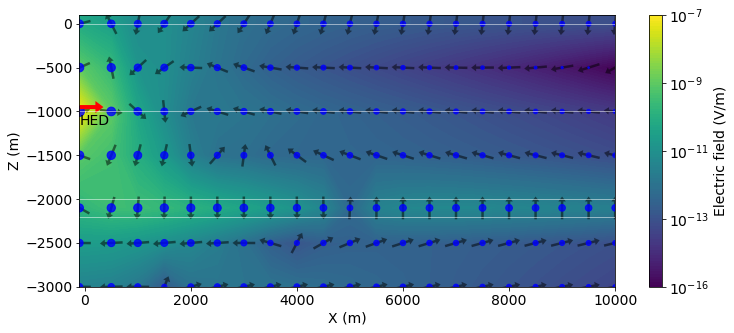

In [8]:
Q1 = interactive(
    csem_fields_app, 
    rho0=FloatText(value=1e8, description='$\\rho_{0} \ (\Omega m)$'), 
    rho1=FloatText(value=0.3, description='$\\rho_{1} \ (\Omega m)$'),
    rho2=FloatText(value=1., description='$\\rho_{2} \ (\Omega m)$'),
    rho3=FloatText(value=100., description='$\\rho_{3} \ (\Omega m)$'),
    rho4=FloatText(value=1., description='$\\rho_{4} \ (\Omega m)$'),
    zsrc=FloatText(value=-950., description='src height (m)'),
    rv_rh=FloatText(value=1., description='$\\rho_{2 \ v} / \\rho_{2 \ h}$'),
    dz1=FloatText(value=1000., description="dz1 (m)"),
    dz2=FloatText(value=1000., description="dz2 (m)"),
    dz3=FloatText(value=200., description="dz3 (m)"),
    frequency = FloatText(value=0.5, description='f (Hz)'),
    Field = ToggleButtons(options =['E','H','P'],value='E'),
    Plane = ToggleButtons(options =['XZ','YZ'],value='XZ'),  
    Fixed=widgets.widget_bool.Checkbox(value=False),
    vmin=FloatText(value=None),    
    vmax=FloatText(value=None),        
    __manual = True
        ); Q1

In [9]:
def csem_data_app(
    frequency, zsrc, zrx,
    rho0, rho1, rho2, rho3, rho4, rv_rh, rho3BG,
    dz1, dz2, dz3, 
    Field, Plane, Component, Complex, scale,
    Fixed, vmin, vmax
    ):

    lamda0, lamda1, lamda2, lamda3, lamda4 = 1., 1., 1., 1., 1.
    d = np.r_[0., np.cumsum(np.r_[dz1, dz2, dz3])]
    depth = [d[0], d[1], d[2], d[3]]       # Layer boundaries
    res =   [rho0,  rho1,  rho2,  rho3, rho4]  # Anomaly resistivities
    resBG =   [rho0,  rho1,  rho2,  rho3BG, rho4]  # Anomaly resistivities    
    aniso = [1., 1., rv_rh, 1., 1.]  # Layer anisotropies (same for anomaly and background)
    anisoBG = [1., 1., 1., 1., 1.]  # Layer anisotropies (same for anomaly and background)    

    # Modelling parameters
    verb = 1

    # Spatial parameters
    dx = 50.
    dy = 50.
    nrx = 200
    x = np.r_[np.arange(nrx)*dx + dx]   # Offsets
    y = np.r_[np.arange(nrx)*dy + dy]   # Offsets    
    z = np.ones_like(x) * -zrx
    srcloc = np.r_[0., 0., -zsrc]
    
    if Plane =="XZ":
        rxlocs = np.c_[x, np.zeros_like(x), z]
        xlabel = "X offset (m)"
        x0 = y.copy()
                        
    elif Plane =="YZ":
        rxlocs = np.c_[np.zeros_like(x), y, z]
        xlabel = "Y offset (m)"
        x0 = x.copy()

    if Field == "E":
        label = "Electric field (V/m)"
        data = csem_layered_earth(srcloc, rxlocs, depth, res, aniso, frequency, rx_direction=Component)            
        dataBG = csem_layered_earth(srcloc, rxlocs, depth, resBG, aniso, frequency, rx_direction=Component)
    elif Field == "H":
        label = "Magnetic field (A/m)"        
        data = csem_layered_earth(srcloc, rxlocs, depth, res, aniso, frequency, rx_direction=Component, rx_type="magnetic")            
        dataBG = csem_layered_earth(srcloc, rxlocs, depth, resBG, aniso, frequency, rx_direction=Component, rx_type="magnetic")                    
    if Complex == "Real":
        val = data.real
        valBG = dataBG.real        
    elif Complex == "Imag":
        val = data.imag        
        valBG = dataBG.imag                
    elif Complex == "Amp":
        val = data.amp
        valBG = dataBG.amp                        
    elif Complex == "Phase":        
        val = data.pha
        valBG = dataBG.pha
        label = "Phase (degree)"
    fig = plt.figure(figsize = (8, 3))
    ax = plt.subplot(111)
    if scale == "log":
        ax.plot(x, abs(val), 'r')
        ax.plot(x, abs(valBG), 'k')    
    elif scale == "linear":
        ax.plot(x, val, 'r')
        ax.plot(x, valBG, 'k')                
    ax.grid(True)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(label) 
    ax.set_yscale(scale)
    ax.legend(("Canonical", "Background"))
    if Complex == "Amp":
        title = "|"+ Field + Component+"|"
    else:
        title = Complex +"("+ Field + Component+")"
    ax.set_title(title)
    if Fixed:
        ax.set_ylim(vmin, vmax)

# Data app

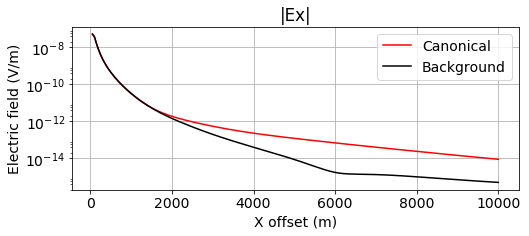

In [10]:
Q2 = interactive(
    csem_data_app, 
    rho0=FloatText(value=1e8, description='$\\rho_{0} \ (\Omega m)$'), 
    rho1=FloatText(value=0.3, description='$\\rho_{1} \ (\Omega m)$'),
    rho2=FloatText(value=1., description='$\\rho_{2} \ (\Omega m)$'),
    rho3=FloatText(value=100., description='$\\rho_{3} \ (\Omega m)$'),
    rho3BG=FloatText(value=1., description='$\\rho_{BG \ 3} \ (\Omega m)$'),    
    rho4=FloatText(value=1., description='$\\rho_{4} \ (\Omega m)$'),
    zsrc=FloatText(value=-950., description='src height (m)'),
    zrx=FloatText(value=-1000., description='rx height (m)'),    
    rv_rh=FloatText(value=1., description='$\\rho_{2 \ v} / \\rho_{2 \ h}$'),
    dz1=FloatText(value=1000., description="dz1 (m)"),
    dz2=FloatText(value=1000., description="dz2 (m)"),
    dz3=FloatText(value=200., description="dz3 (m)"),
    frequency = FloatText(value=0.5, description='f (Hz)'),
    Field = ToggleButtons(options =['E','H'],value='E'),
    Plane = ToggleButtons(options =['XZ','YZ'],value='XZ'), 
    Component = ToggleButtons(options =['x','y', 'z'], value='x', description="rx direction"), 
    Complex = ToggleButtons(options =['Real','Imag', "Amp", "Phase"],value='Amp'),
    scale = ToggleButtons(options =['log','linear'], value='log'), 
    Fixed=widgets.widget_bool.Checkbox(value=False),
    vmin=FloatText(value=None),    
    vmax=FloatText(value=None),    
    __manual = True
        )
display(Q2)